*Importing Libraries*

In [60]:
import zipfile
import os
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import os
import cv2
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib

*Setting up Kaggle and Downloading Diabetic Retinopathy Dataset*

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged

# Open the zip file
with zipfile.ZipFile("/content/diabetic-retinopathy-resized-arranged.zip", "r") as zip_ref:
    # Extract all contents of the zip file to the current working directory
    zip_ref.extractall()

100% 1.21G/1.21G [00:16<00:00, 50.3MB/s]
100% 1.21G/1.21G [00:16<00:00, 80.4MB/s]


*Data Preparation and Pair Generation for Left-Eye and Right-Eye Images with Class Mapping*

In [63]:
# Define a lambda function to map class labels into new values (from 5 to 3 classes)
map = lambda x: 0 if x == 0 else (1 if (x == 1 or x == 2) else (2 if (x == 3 or x == 4) else 4))

# Create a list of file paths for left-eye images for each class (0 to 4)
le = ["/content/"+str(i) + "/" + left for i in range(5) for left in os.listdir("/content/"+str(i)) if left.endswith("_left.jpeg")]

# Create a list of file paths for right-eye images with mapped class values
ri = ["/content/"+str(i) + "/" + right+"@"+str(map(i)) for i in range(5) for right in os.listdir("/content/"+str(i)) if right.endswith("_right.jpeg")]

# Define a function to create pairs of left-eye and right-eye images with their respective classes
def pairs(le, ri):
    return [[left, right.split("@")[0], right.split("@")[1]] for left in le for right in ri if left.split("_")[0] == right.split("_")[0]]

# Generate the pairs of left-eye and right-eye images with their respective classes
pi = pairs(le, ri)

# Create a pandas DataFrame to store the pairs data with columns ['leftEye', 'rightEye', 'class']
df = pd.DataFrame(pi, columns=['leftEye', 'rightEye', 'class'])

*Displaying the First Few Rows of DataFrame*

In [64]:
print("First few rows:")
print(df.head())

First few rows:
                      leftEye                     rightEye class
0  /content/0/16631_left.jpeg  /content/0/16631_right.jpeg     0
1  /content/0/25811_left.jpeg  /content/0/25811_right.jpeg     0
2  /content/0/29975_left.jpeg  /content/0/29975_right.jpeg     0
3  /content/0/24089_left.jpeg  /content/0/24089_right.jpeg     0
4  /content/0/33081_left.jpeg  /content/0/33081_right.jpeg     0


*Exploring DataFrame Shape and Summary Statistics*

In [65]:
print("DataFrame Shape:", df.shape)
df.describe()

DataFrame Shape: (15323, 3)


,leftEye,rightEye,class
count,15323,15323,15323
unique,15323,15323,3
top,/content/0/16631_left.jpeg,/content/0/16631_right.jpeg,0
freq,1,1,12155


*Visualizing Class Distribution Before and After Balancing*

<ipython-input-66-96dfe632cc16>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_balanced = df[:len(df[df['class'] == '2'])].append(df[df["class"] == '1'][:len(df[df['class'] == '2'])]).append(df[df["class"] == "2"])
<ipython-input-66-96dfe632cc16>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_balanced = df[:len(df[df['class'] == '2'])].append(df[df["class"] == '1'][:len(df[df['class'] == '2'])]).append(df[df["class"] == "2"])


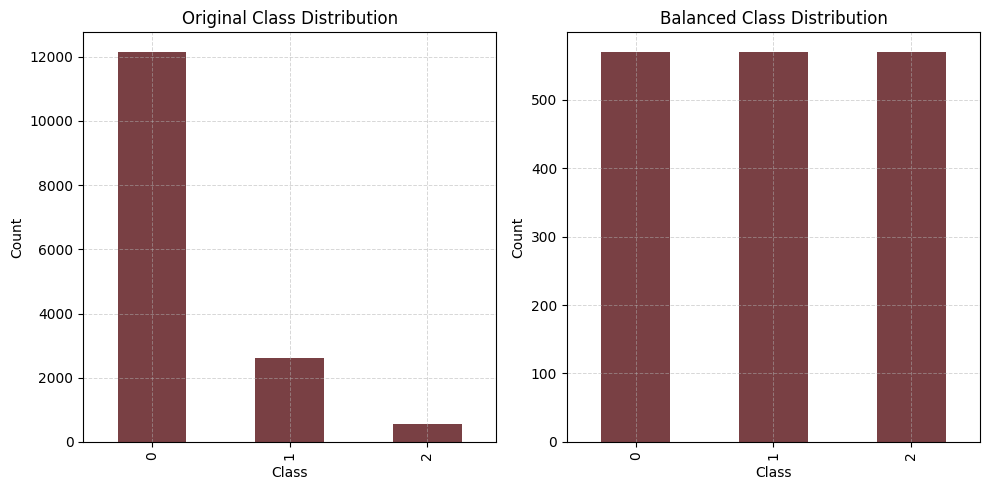

In [66]:
# get the class distribution
class_counts_original = df['class'].value_counts()

# create a new DataFrame with balanced classes (equal number of samples for class 1 and 2)
df_balanced = df[:len(df[df['class'] == '2'])].append(df[df["class"] == '1'][:len(df[df['class'] == '2'])]).append(df[df["class"] == "2"])

# get the class distribution for the balanced DataFrame
class_counts_balanced = df_balanced['class'].value_counts()

# plot both class distributions side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot the original class distribution
class_counts_original.plot(kind='bar', ax=ax1, color="#794044")
ax1.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Original Class Distribution')


# plot the balanced class distribution
class_counts_balanced.plot(kind='bar', ax=ax2, color="#794044")
ax2.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Balanced Class Distribution')


plt.tight_layout()
plt.savefig('Data_distribution_before_and_after_balancing.png', transparent=True)
plt.show()

*Visualization of Left and Right Eye Classes*

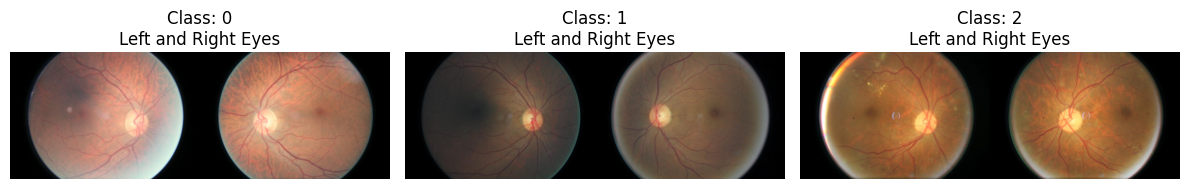

In [67]:
# Group the data by class
grouped_by_class = df.groupby('class')

# Get the unique eye classes
unique_classes = df['class'].unique()

# Create subplots for each class
num_plots = len(unique_classes)
fig, axes = plt.subplots(1, num_plots, figsize=(12, 4))

# Plot each eye class separately
for i, eye_class in enumerate(unique_classes):
    ax = axes[i]
    data_for_class = grouped_by_class.get_group(eye_class)

    left_eye_path = data_for_class['leftEye'].iloc[0]
    right_eye_path = data_for_class['rightEye'].iloc[0]

    left_eye_img = mpimg.imread(left_eye_path)
    right_eye_img = mpimg.imread(right_eye_path)

    # Combine left and right eye images for visualization
    combined_img = np.concatenate([left_eye_img, right_eye_img], axis=1)

    ax.imshow(combined_img)
    ax.set_title(f'Class: {eye_class}\nLeft and Right Eyes')
    ax.axis('off')

plt.tight_layout()  # Adjust subplot spacing and title position
plt.savefig('Left_and_Right_Eyes_Classes.png', transparent=True)
plt.show()

*Image Preprocessing and Data Preparation for Eye Classification*

In [68]:
def import_eyes_images(df, Eye):
    images_eye = []
    labels = []
    for index, row in df.iterrows():
        eye_path = row[Eye+'Eye']
        label = float(row['class'])

        # Load and resize eye eye image
        eye = cv2.imread(eye_path)
        eye = cv2.resize(eye, (224, 224))

        # Append eye and right eye images to images list
        images_eye.append(eye)

        # Append label to labels list
        labels.append(label)

    # Convert lists to numpy arrays
    images_eye = np.array(images_eye)
    labels = np.array(labels)

    return images_eye, labels

n_class = 3

x_data, y_data = import_eyes_images(df_balanced, 'left')

x_data = x_data.astype('float32')
x_data = np.reshape(x_data, (x_data.shape[0], 224*224*3))
x_data /= 255
print('x_data shape:', x_data.shape)
print(x_data.shape[0], 'data samples')

x_data shape: (1710, 150528)
1710 data samples


*Converting Images and Labels to a Pandas DataFrame*

In [69]:
"""## Convert images and label vector to a Pandas DataFrame"""
feat_cols = [ 'pixel'+str(i) for i in range(x_data.shape[1]) ]
df = pd.DataFrame(x_data, columns=feat_cols)
df['y'] = y_data
df['label'] = df['y'].apply(lambda i: str(i))
x_data, y_data = None, None
print('Size of the dataframe: {}'.format(df.shape))
df.head()

Size of the dataframe: (1710, 150530)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel150520,pixel150521,pixel150522,pixel150523,pixel150524,pixel150525,pixel150526,pixel150527,y,label
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003922,0.007843,0.0,0.003922,0.007843,0.0,0.003922,0.007843,0.0,0.003922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*Visualizing Images from the DataFrame - Random Sampling of Different Classes*

<Figure size 640x480 with 0 Axes>

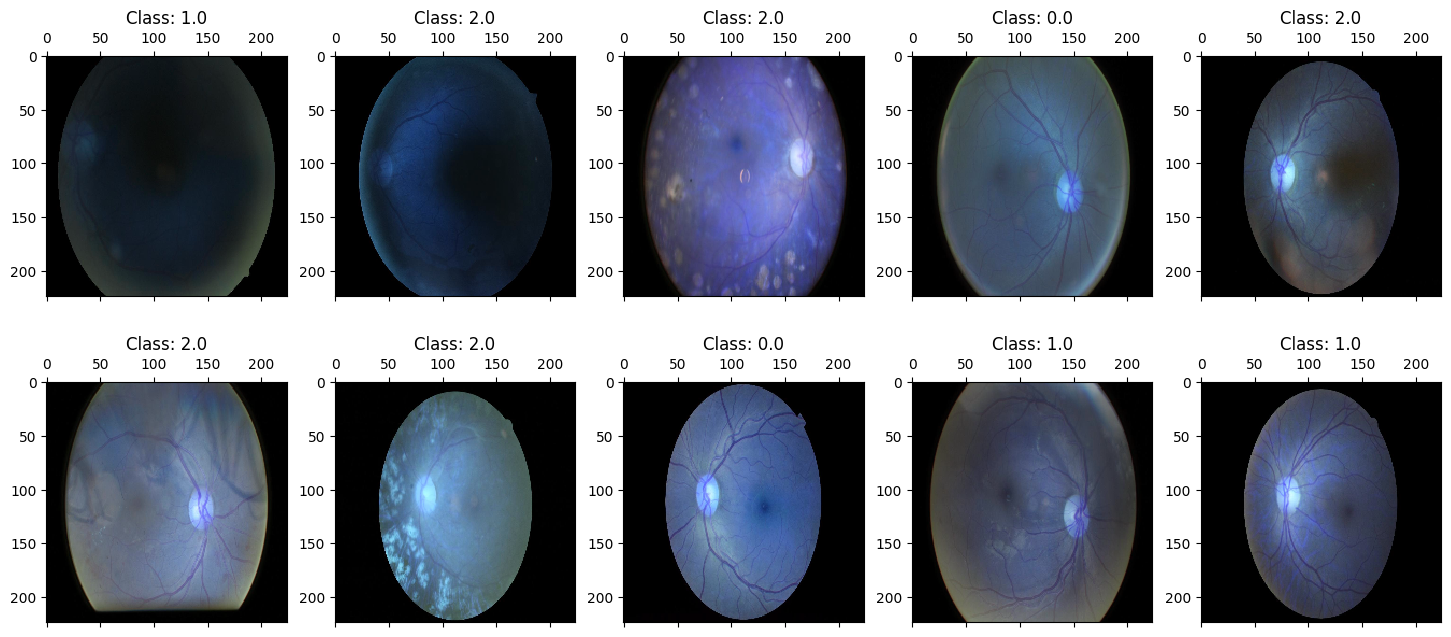

In [70]:
"""## Displaying images from the Dataframe"""
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

plt.gray()
fig = plt.figure( figsize=(18,12) )
for i in range(0,10):
    ax = fig.add_subplot(3,5,i+1, title="Class: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((224,224, 3)).astype(float))
plt.savefig('Differents_classes.png', transparent=True)
plt.show()

*t-SNE Algorithm for Dimensionality Reduction: Visualizing High-Dimensional Data*

In [40]:
"""##Launch of the T-SNE algorithm"""

N = 50000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1710 samples in 3.696s...
[t-SNE] Computed neighbors for 1710 samples in 38.751s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1710
[t-SNE] Computed conditional probabilities for sample 1710 / 1710
[t-SNE] Mean sigma: 13.638899
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.745399
[t-SNE] KL divergence after 300 iterations: 1.171124
t-SNE done! Time elapsed: 57.129910707473755 seconds


*t-SNE Visualization of DataFrame with Custom Color Palette*

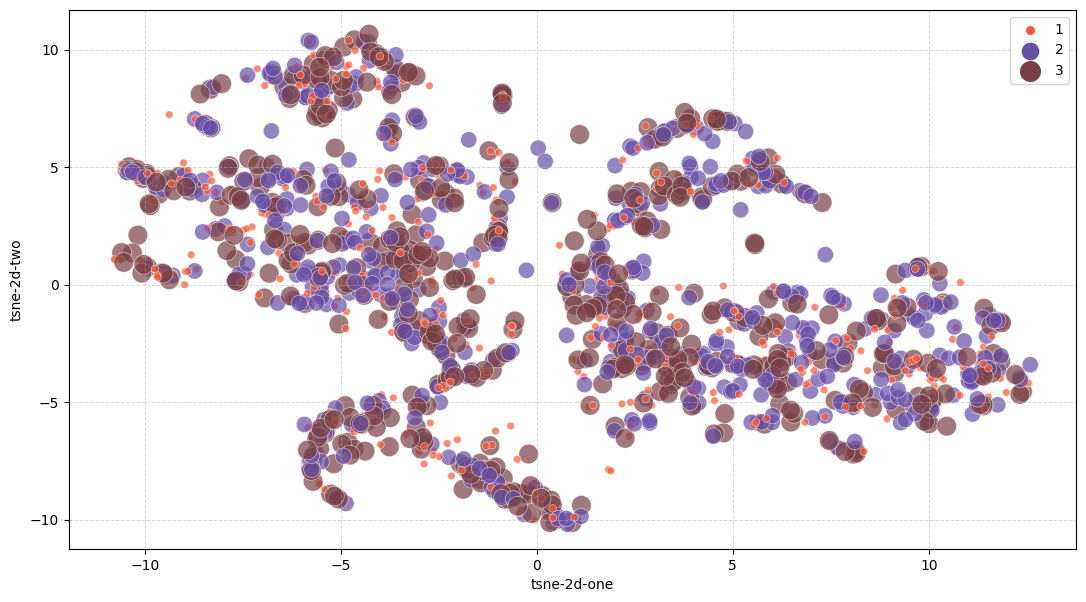

In [71]:
# Example DataFrame
df_subset = pd.DataFrame({
    'tsne-2d-one': tsne_results[:, 0],
    'tsne-2d-two': tsne_results[:, 1],
    'y': np.random.choice([1, 2, 3], size=tsne_results[:, 0].shape[0])
})

plt.figure(figsize=(13, 7))

# Define your own custom color palette
custom_palette = ['#FF5733', '#674ea7', '#794044']

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=custom_palette,
    size="y",  # Use the "y" column to determine the size of the points
    sizes=(30, 200),  # Define the range of point sizes (adjust as needed)
    size_norm=matplotlib.colors.LogNorm(),  # Use logarithmic normalization for sizes
    data=df_subset,
    legend="full",
    alpha=0.7
)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)
plt.savefig('Tsne_visualization.png', transparent=True)
plt.show()


*Exporting Balanced Data to CSV: df_balanced to balancedData.csv*

In [61]:
df_balanced.to_csv("balancedData.csv")